In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

In [65]:
import os 
DATA_DIR = "/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution"


demo_dirs = os.listdir(DATA_DIR)
# filter out directories that are not demos
demo_dirs = [d for d in demo_dirs if os.path.isdir(os.path.join(DATA_DIR, d))]
# sort by name
demo_dirs.sort()
print(f"Found {len(demo_dirs)} demonstrations")


# ðemo dir 
#  back_camera
# data.mp4

video_paths = [os.path.join(DATA_DIR, demo_dir, "back_camera", "data.mp4") for demo_dir in demo_dirs]
print(video_paths)

Found 31 demonstrations
['/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_0/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_1/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_10/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_11/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_12/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_13/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_14/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_15/back_camera/data.mp4', '/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullre

In [66]:
# get initial frames for each video

initial_frames = []
for video_path in video_paths:
    video = cv2.VideoCapture(video_path)
    ret, frame = video.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    initial_frames.append(frame)

# save the initial frames
initial_frames = np.array(initial_frames)

In [ ]:
# # instead, now get all frames of a single video
# url = "/home/tlips/Code/few-shot-keypoints/data/RPL-clean-pen/3mark_1arm_fullresolution/demo_14/back_camera/data.mp4"

# import imageio.v3 as iio
# frames = iio.imread(url, plugin="FFMPEG")  # plugin="pyav"
# # frames = frames[-1100:-800]
# print(len(frames))
# initial_frames = frames[::30]
# print(len(initial_frames))

1065
36


In [6]:
# # add the scene view from the initial frame
# initial_scene_view = iio.imread(url.replace("right_camera", "back_camera"), plugin="FFMPEG")[0]

# # add to initial frames
# initial_frames = np.concatenate([ [initial_scene_view], initial_frames])

# save the initial frames


In [7]:


# show the initial frames
# fig ,ax = plt.subplots(len(initial_frames) // 5+1, 5, figsize=(len(initial_frames) // 5 * 3, len(initial_frames) // 5 * 3))
# for i, frame in enumerate(initial_frames):
#     ax[i // 5, i % 5].imshow(frame)
#     ax[i // 5, i % 5].axis("off")
#     ax[i // 5, i % 5].set_title(f"Demo {i}")
# plt.show()

In [56]:
from transformers import AutoModelForZeroShotObjectDetection, AutoProcessor
model_id =  "IDEA-Research/grounding-dino-tiny"
device = "cuda"
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
processor = AutoProcessor.from_pretrained(model_id)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [57]:
def get_bounding_boxes(img, text_labels):
    # https://github.com/huggingface/transformers/blob/main/src/transformers/models/grounding_dino/processing_grounding_dino.py
    
    text_labels = [text_labels]
    inputs = processor(text=text_labels, images=img, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    results = processor.post_process_grounded_object_detection(outputs, inputs.input_ids,threshold=0.3, target_sizes=[img.shape[:2]])
    return results[0]

def get_bounding_boxes_per_category(img, text_labels):
    # get the bounding boxes for each category
    results = get_bounding_boxes(img, text_labels)
    # sort them by category
    results_per_category = {}
    for label in text_labels:
        results_per_category[label] = []
        for bbox,bbox_label,score in zip(results['boxes'], results['labels'], results['scores']):
            if bbox_label == label:
                results_per_category[label].append((bbox,score))

In [58]:
objects = [ "pen" ,"box"]
per_object_keypoints = {object: [] for object in objects}

In [67]:
color_list = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'brown', 'pink', 'gray', 'black']

def click_callback(img_coords, ax, fig):
    def onclick(event):
        """
        This function is called when you click on the image.
        It appends the (x, y) coordinates to the 'coords' list.
        """
        # event.xdata and event.ydata are the floating point coordinates of the click
        if event.xdata is not None and event.ydata is not None:
            ix, iy = int(event.xdata), int(event.ydata)
            print(f'Clicked at x={ix}, y={iy}')
            img_coords.append((ix, iy))
            ax.scatter(ix, iy, c=color_list[len(img_coords) % len(color_list)], s=50)
            fig.canvas.draw()
    return onclick

In [68]:

support_image_id = 0

support_img = np.array(initial_frames[support_image_id])
# drop that image from the list of initial frames, deal with edge case of having first or last image!
if support_image_id == 0:
    initial_frames = initial_frames[1:]
elif support_image_id == len(initial_frames) - 1:
    initial_frames = initial_frames[:-1]
else:
    initial_frames = initial_frames[:support_image_id] + initial_frames[support_image_id+1:]



In [69]:
detection_results = get_bounding_boxes(support_img, objects)

# sort them by category

objects_to_bboxes = {}
for object in objects:
    object_results = []
    for bbox,bbox_label,score in zip(detection_results['boxes'], detection_results['labels'], detection_results['scores']):
        if bbox_label == object:
            object_results.append((bbox,score))
    if len(object_results) == 0:
        raise ValueError(f"No bounding boxes found for object {object}")
    # find the bbox with highest score
    best_bbox = max(object_results, key=lambda x: x[1])
    objects_to_bboxes[object] = best_bbox[0].cpu().numpy()


# now get the keypoints for each object

for object,bbox in objects_to_bboxes.items():
    print(object, bbox)

pen [115.43768 263.83954 211.58896 353.1419 ]
box [300.39084 161.93607 396.09344 297.2321 ]


In [62]:
from mobile_sam import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

model_type = "vit_t"
sam_checkpoint = "../MobileSAM/weights/mobile_sam.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"

mobile_sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
mobile_sam.to(device=device)
mobile_sam.eval()
mobile_sam_predictor = SamPredictor(mobile_sam)



In [72]:
def get_masked_image(img, bbox,padding=10, use_mobile_sam=False):
    x1, y1, x2, y2 = bbox
    x1 = int(x1)
    y1 = int(y1)
    x2 = int(x2)
    y2 = int(y2)

    if not use_mobile_sam:
        x1 = max(0, x1 - padding)
        y1 = max(0, y1 - padding)
        x2 = min(img.shape[1], x2 + padding)
        y2 = min(img.shape[0], y2 + padding)

        masked_img = np.zeros_like(img)
        masked_img[y1:y2, x1:x2] = img[y1:y2, x1:x2].copy()
        return masked_img, None
    else:
        #TOOD: should only predict features once for each image! 
        mobile_sam_predictor.set_image(img)
        mask,_,_ = mobile_sam_predictor.predict(box=np.array([x1,y1,x2,y2]))
        # convert to RGB mask 
        mask = mask.transpose(1,2,0)
        masked_img = np.zeros_like(img)
        masked_img[mask] = img[mask]
        return masked_img, mask


(480, 640, 3)


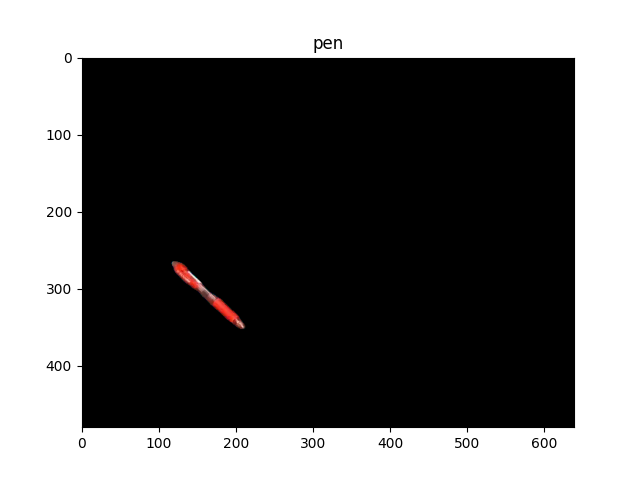

/tmp/ipykernel_3234384/3877659608.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


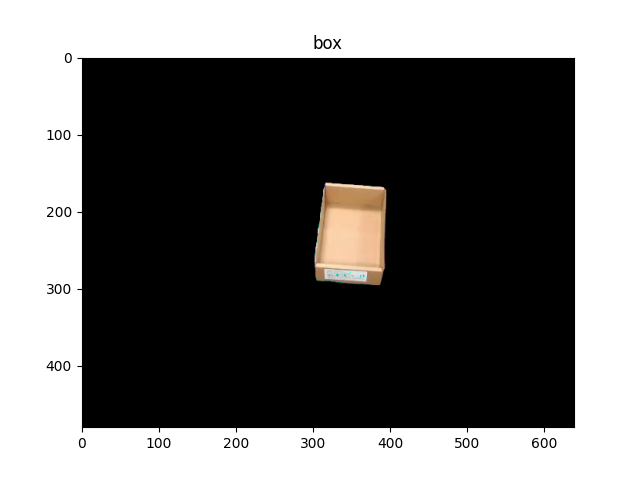

In [75]:
# draw subplots for each figure and have a clickable callback to add keypoints to the list for an image with the masked bbox

print(support_img.shape)



for object in objects:
    fig, ax = plt.subplots()
    ax.imshow(get_masked_image(support_img, objects_to_bboxes[object],use_mobile_sam=True)[0])
    ax.set_title(object)
    cid = fig.canvas.mpl_connect('button_press_event', click_callback(per_object_keypoints[object], ax, fig))
    plt.show()





In [16]:
raise ValueError("first annotate the keypoints")

ValueError: first annotate the keypoints

In [76]:
for category in objects:
    print(f"annotated {len(per_object_keypoints[category])} keypoints for {category}")

annotated 3 keypoints for pen
annotated 3 keypoints for box


In [77]:
from few_shot_keypoints.featurizers import FeaturizerRegistry
from few_shot_keypoints.matcher import KeypointFeatureMatcher, KeypointListMatcher
import torch 
from torchvision import transforms

to_tensor_tf = transforms.Compose([
    transforms.ToTensor(),
])

# featurizer = FeaturizerRegistry.create("dift-sd2.1-e1")
# featurizer = FeaturizerRegistry.create("dift-sd2.1-e8")
featurizer = FeaturizerRegistry.create("dinov2-s")
# featurizer = FeaturizerRegistry.create("dinov3-l")


# matchers = []
# for keypoint in img_coords_1:
#     matcher = KeypointFeatureMatcher(featurizer)
#     matcher.add_reference_image(to_tensor_tf(support_img).unsqueeze(0), [keypoint[0], keypoint[1]])
#     matchers.append(matcher)



object_to_matchers = {}
for object in objects:
    object_to_matchers[object] = [] 
    for keypoint in per_object_keypoints[object]:
        matcher = KeypointFeatureMatcher(featurizer)
        matcher.add_reference_image(to_tensor_tf(support_img).unsqueeze(0), [keypoint[0], keypoint[1]])
        object_to_matchers[object].append(matcher)




In [78]:
def get_per_object_keypoints(img, categories,object_to_matchers):
    results = {category: [] for category in categories}
    for category in categories:
        bboxes = get_bounding_boxes(img, [category])["boxes"]
        for bbox in bboxes:
            masked_image, mask = get_masked_image(img, bbox, use_mobile_sam=True)
            keypoints = get_keypoints(masked_image,object_to_matchers[category])
            results[category].append((bbox, keypoints, mask))
    return results


def get_keypoints(img, object_to_matchers):
    keypoints = []
    for matcher in object_to_matchers:
        kp = matcher.get_best_match(to_tensor_tf(img).unsqueeze(0))
        keypoints.append(kp)
    return keypoints


per_object_matches = get_per_object_keypoints(support_img, objects, object_to_matchers)


In [83]:
# for each initial frame, search for the best keypoint match for each keypoint.

per_frame_results = []
for frame in initial_frames:
    per_frame_results.append(get_per_object_keypoints(frame, objects, object_to_matchers))


# for each frame, get the keypoint with the highest confidence score


In [101]:
def get_mask_contour(mask):
    mask = mask[...,0]
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # get longest contour
    contour = max(contours, key=lambda x: cv2.arcLength(x, True))
    contour = [x[0] for x in contour]
    contour = np.array(contour)
    return contour



mask = per_object_matches[objects[0]][0][2]
print(mask.shape)
print(get_mask_contour(mask))



(480, 640, 3)
[[258 197]
 [257 198]
 [250 198]
 [249 199]
 [243 199]
 [242 200]
 [240 200]
 [239 201]
 [234 201]
 [233 202]
 [225 202]
 [224 203]
 [217 203]
 [216 204]
 [208 204]
 [207 205]
 [202 205]
 [201 206]
 [200 205]
 [197 205]
 [196 204]
 [189 204]
 [188 205]
 [182 205]
 [181 206]
 [175 206]
 [174 207]
 [169 207]
 [168 208]
 [163 208]
 [162 209]
 [160 209]
 [159 210]
 [157 210]
 [156 211]
 [154 211]
 [153 212]
 [151 212]
 [150 213]
 [148 213]
 [148 214]
 [147 215]
 [147 216]
 [148 217]
 [149 217]
 [150 218]
 [153 218]
 [154 219]
 [162 219]
 [163 220]
 [168 220]
 [169 219]
 [178 219]
 [179 218]
 [186 218]
 [187 217]
 [191 217]
 [192 216]
 [195 216]
 [196 215]
 [197 215]
 [199 213]
 [211 213]
 [212 212]
 [223 212]
 [224 213]
 [228 213]
 [229 214]
 [237 214]
 [238 213]
 [248 213]
 [249 212]
 [251 212]
 [252 211]
 [254 211]
 [255 210]
 [257 210]
 [258 209]
 [259 209]
 [260 208]
 [261 208]
 [262 207]
 [263 207]
 [264 206]
 [267 206]
 [268 205]
 [271 205]
 [273 203]
 [273 202]
 [274 2

MatchingResult(u=263, v=191, score=0.8424)
MatchingResult(u=203, v=204, score=0.7917)
MatchingResult(u=153, v=218, score=0.8315)
MatchingResult(u=126, v=268, score=0.7989)
MatchingResult(u=171, v=313, score=0.7759)
MatchingResult(u=206, v=345, score=0.8448)
MatchingResult(u=174, v=162, score=0.6149)
MatchingResult(u=185, v=162, score=0.5915)
MatchingResult(u=263, v=148, score=0.5852)
MatchingResult(u=303, v=268, score=0.895)
MatchingResult(u=390, v=269, score=0.9081)
MatchingResult(u=390, v=178, score=0.9039)


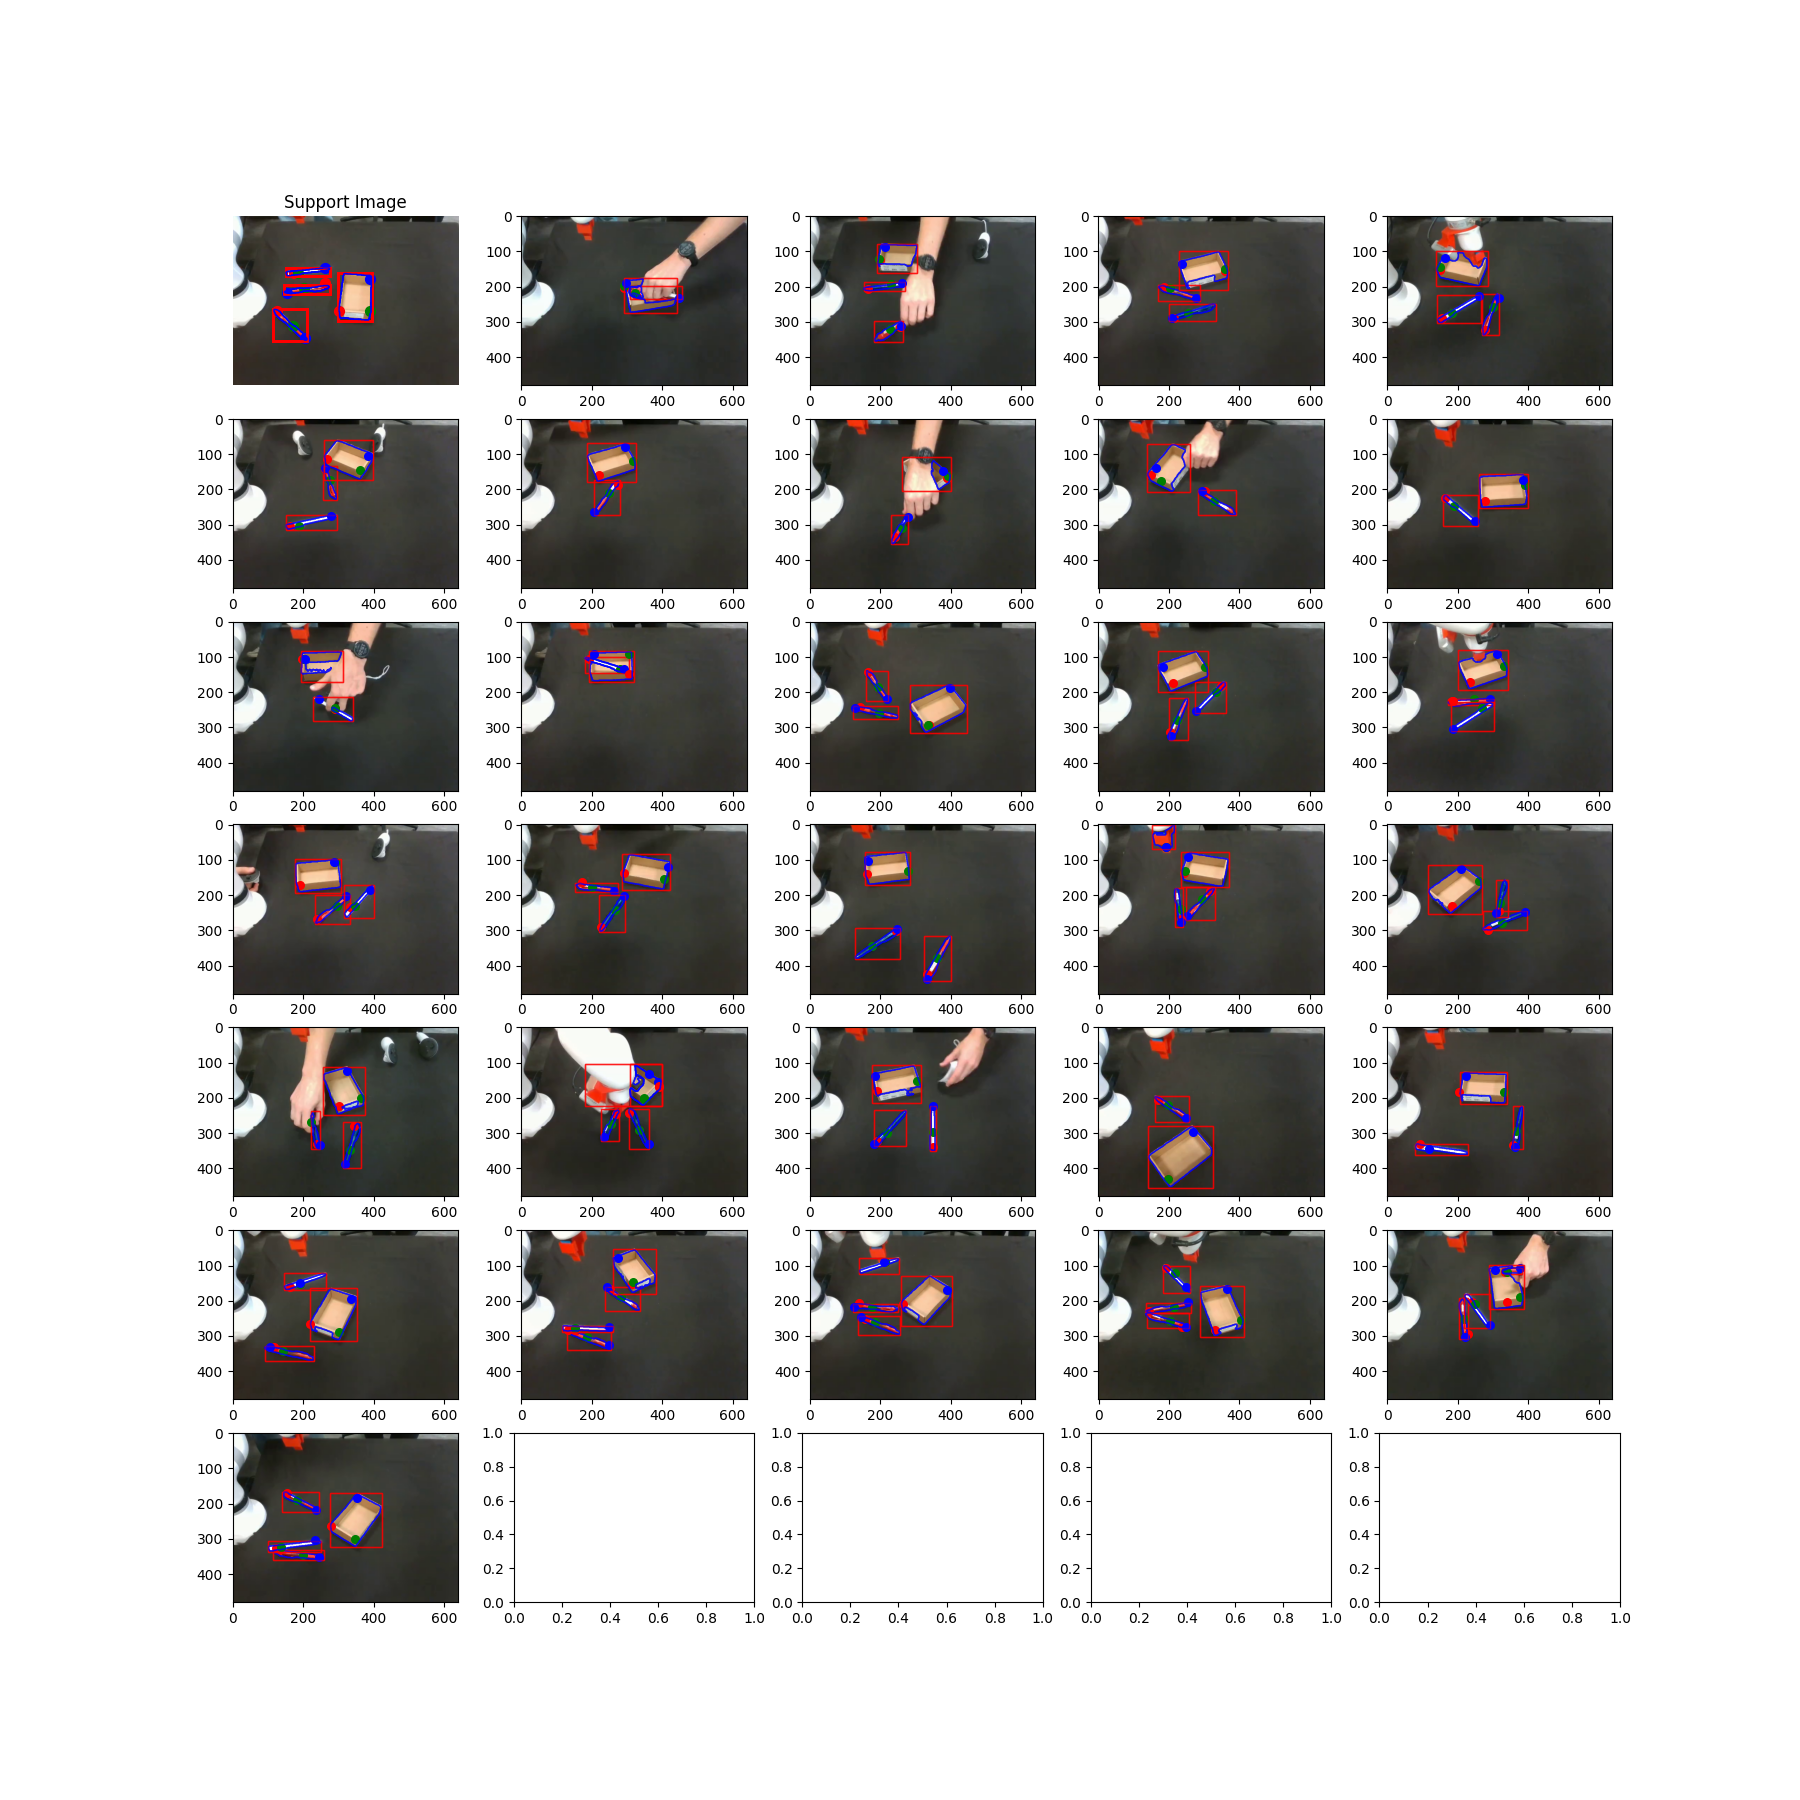

In [104]:
# visualize the keypoint matches
fig ,ax = plt.subplots(len(initial_frames) // 5+1, 5, figsize=(len(initial_frames) // 5 * 3, len(initial_frames) // 5 * 3))
ax[0,0].axis("off")
ax[0,0].set_title("Support Image")
ax[0,0].imshow(support_img)
for category in objects:
    for object_matches in per_object_matches[category]:
        bbox, kps, mask = object_matches
        bbox = bbox.cpu().numpy()
        for kp_idx, kp in enumerate(kps):
            print(kp)
            ax[0,0].scatter(kp.u, kp.v, c=color_list[kp_idx % len(color_list)], s=50)
            ax[0,0].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='red', linewidth=2))
            if mask is not None:
                mask_contour = get_mask_contour(mask)
                ax[0,0].add_patch(plt.Polygon(mask_contour, fill=False, edgecolor='blue', linewidth=1))

            # add confidence score
            # ax[0,0].text(kp.u, kp.v, f"{int(100*kp.score)}", color=color_list[category % len(color_list)], fontsize=10)

for img_idx, img in enumerate(initial_frames):
    plt_img_idx = img_idx +1 # first image is the support image
    img_keypoints = per_frame_results[img_idx]
    ax[plt_img_idx // 5, plt_img_idx % 5].imshow(img)
    for category in objects:
        for object_matches in per_frame_results[img_idx][category]:
            bbox, kps, mask = object_matches
            bbox = bbox.cpu().numpy()
            for kp_idx, kp in enumerate(kps):
                ax[plt_img_idx // 5, plt_img_idx % 5].scatter(kp.u, kp.v, c=color_list[kp_idx % len(color_list)], s=30,alpha=1.0)
                ax[plt_img_idx // 5, plt_img_idx % 5].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], fill=False, edgecolor='red', linewidth=1,alpha=0.5))
                if mask is not None:
                    mask_contour = get_mask_contour(mask)
                    ax[plt_img_idx // 5, plt_img_idx % 5].add_patch(plt.Polygon(mask_contour, fill=False, edgecolor='blue', linewidth=1,alpha=0.5))
        # add confidence score
        # ax[plt_img_idx // 5, plt_img_idx % 5].text(kp.u, kp.v, f"{int(100*kp.score)}", color=color_list[kp_idx % len(color_list)], fontsize=10)
plt.show()

# for idx, kp in enumerate(img_coords_1):
#     ax[0,0].scatter(kp[0], kp[1], c=color_list[idx % len(color_list)], s=50)
# for img_idx, img in enumerate(initial_frames):
#     plt_img_idx = img_idx +1 # first image is the support image
#     img_keypoints = keypoint_matches[img_idx]
#     ax[plt_img_idx // 5, plt_img_idx % 5].imshow(img)
#     for kp_idx, kp in enumerate(img_keypoints):
#         ax[plt_img_idx // 5, plt_img_idx % 5].scatter(kp.u, kp.v, c=color_list[kp_idx % len(color_list)], s=50)
#         # add confidence score
#         # ax[plt_img_idx // 5, plt_img_idx % 5].text(kp.u, kp.v, f"{int(100*kp.score)}", color=color_list[kp_idx % len(color_list)], fontsize=10)
# plt.show()


In [ ]:
# compile the frames and annotations into a video 
# get distinct colors for each keypoint
color_list = plt.cm.tab10.colors

annotated_frames = []
for frame_idx in range(len(initial_frames)):
    frame = initial_frames[frame_idx]
    annotated_frame = frame.copy()
    img_keypoints = keypoint_matches[frame_idx]
    for kp_idx, kp in enumerate(img_keypoints):
        color = color_list[kp_idx % len(color_list)]
        color = (int(color[0]*255), int(color[1]*255), int(color[2]*255))
        annotated_frame = cv2.circle(annotated_frame, (kp.u, kp.v), 5,color, -1)
        # write cofindence score on the annotated frame
        cv2.putText(annotated_frame, str(int(kp.score*100)), (kp.u, kp.v), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    annotated_frames.append(annotated_frame)

# save the annotated frames
iio.imwrite("videos/correspondence-episode-wrist.mp4", annotated_frames, plugin="FFMPEG")

    